# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 4 K-Means Clustering ##

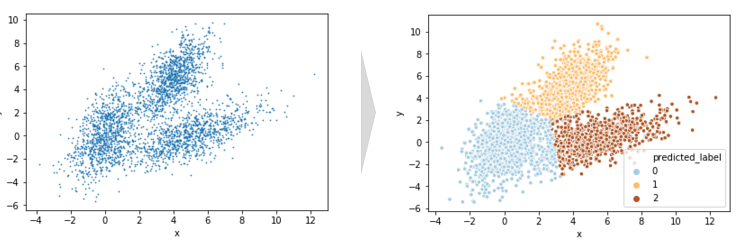

## Tasks

To better understand K-means clustering, in this lab, you will implement K-means clustering from scratch with the help of NumPy. In the second part, we will look into how different parameters might alter the output of the algorithms.

Please run the following cells and do not modify anything.

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import mode
import numpy as np

def let_me_see(X, k, labels, centroids, is_class=False):
    if is_class:
        title = 'Class'
    else:
        title = 'Cluster'
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    markers = ['o', '^', 's', 'v', 'p', '*']

    # two subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # first subplot: plot along 1st and 2nd features
    plt.subplot(1, 2, 1)
    for i in range(k):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], marker=markers[i], label=f'{title} {i+1}')

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='*', label='Centroids')
    plt.xlabel('Sepal Length (cm)')
    plt.ylabel('Sepal Width (cm)')
    plt.legend()

    # second subplot: plot along 3rd and 4th features
    plt.subplot(1, 2, 2)
    for i in range(k):
        plt.scatter(X[labels == i, 2], X[labels == i, 3], c=colors[i], marker=markers[i], label=f'{title} {i+1}')

    if centroids is not None:
        plt.scatter(centroids[:, 2], centroids[:, 3], c='k', marker='*', label='Centroids')
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.legend()

    # show the plot
    plt.show()

def align_labels(y_true, y_pred):
    aligned_y_pred = np.zeros_like(y_pred)
    for i in range(3):
        mask = (y_pred == i)
        aligned_y_pred[mask] = mode(y_true[mask])[0]
    return aligned_y_pred

# Prepare Dataset

### Dataset Introduction:
What do the instances in this dataset represent?

Each instance is a plant. This is one of the earliest datasets used in the literature on classification methods and widely used in statistics and machine learning.  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is linearly separable from the other 2; the latter are not linearly separable from each other.

Predicted attribute: class of iris plant.

This is an exceedingly simple domain.

This data differs from the data presented in Fishers article (identified by Steve Chadwick,  spchadwick@espeedaz.net ).  The 35th sample should be: 4.9,3.1,1.5,0.2,"Iris-setosa" where the error is in the fourth feature. The 38th sample: 4.9,3.6,1.4,0.1,"Iris-setosa" where the errors are in the second and third features.  


### Some convention of notation:

Attention: N,d,K might be different when grading. Don't hard code them in your code

N: number of samples (here is 150 for this iris dataset)

d: number of features (here is 4 for this iris dataset)

K: number of clusters (here is 3 for this iris dataset)

**PS**: although the dataset contains the class label information (i.e., three species of Iris), we use it as a clustering problem, i.e., an unsupervised learning problem. So the label information (given by y = iris.target) won’t be used during learning (Task 1). It will only be used to check the accuracy of the clustering results (Task 2.2).

In [5]:
############ load iris flower dataset ############
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
# 4 features: Petal Length, Petal Width, Sepal Length, Sepal width
y = iris.target
# 0, 1, 2, three Classes(Species)

############ show the dataset ############
print('X.shape:', X.shape)
print('y.shape:', y.shape)
print(f'X[0:5]:\n{X[0:5]}')
print(f'y[0:5]:\n{y[0:5]}')

X.shape: (150, 4)
y.shape: (150,)
X[0:5]:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
y[0:5]:
[0 0 0 0 0]


# Task 1 K-Means Algorithm
The overall four steps are:
1. Randomly choose K samples to be the initial centroids.
2. Calculate the distance between samples and centroids.
3. Assign each data point to the nearest centroid.
4. Update the centroids based on the mean of the data points assigned to them.

The above-mentioned pipeline is already implemented, which is the "fit" function, and please do not modify it.

For Task 1, there are three sub-tasks need to be implemented:

### TODO 1.1
Calculate the **Euclidean distance** (also known as L2 distance) between each sample and the current centroids.

Euclidean distance formula:
$$ d(x, y) = \sqrt{\sum_{i=1}^{d}(x_i - y_i)^2} $$

Function name: calculate_distance

Input:
- "X": a 2D Numpy array with shape (N, d), which contains all the data samples.
- "centroids": a 2D Numpy array with shape (K, d), which represents the current centroids.

Output:
- "distances": a 2D Numpy array with shape (N, K), which is the distance between each sample and each centroid.

### TODO 1.2
Assign each data point to the nearest centroid.

Function name: assign_cluster

Input:
- "distances": a 2D Numpy array with shape (N, K), which is the distance between each sample and each centroid.

Output:
- "labels": a 1D Numpy array with shape (N, ), which is the cluster index for each sample.

### TODO 1.3
Update the centroids based on the mean of the data points assigned to them.

Function name: update_centroids

Input:
- "X": a 2D Numpy array with shape (N, d), which is all the data samples.
- "centroids": a 2D Numpy array with shape (K, d), which represents the current centroids.
- "labels": a 1D Numpy array with shape (N, ), which is current assigned label for each sample.

Output:
- "centroids": a 2D Numpy array with shape (K, d), which contains the updated centroids.

### Code Cell of Task 1

In [12]:
############ Implement K-Means with numpy ############
import numpy as np

class KMeans:
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.first_iter = True

    def calculate_distance(self, X, centroids):
        # TODO 1.1
        # Calculate the distance between each data point and each centroid
        # Hint: You may consider using
            # np.newaxis: https://numpy.org/doc/stable/reference/arrays.indexing.html
            # np.sum: https://numpy.org/doc/stable/reference/generated/numpy.sum.html
            # np.sqrt: https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html
        # in case you don't know how to use them, here is an example:
        # consider print the shape of X and centroids
        # print(X.shape)
        # print(centroids.shape)
        X_i = np.expand_dims(X,axis=1)
        centroids_i = np.expand_dims(centroids,axis=0)
        distances = np.sqrt(np.sum((X_i-centroids_i)**2,axis=2))

        if self.first_iter:
            print(f"distances[0:5]:\n{distances[0:5]}") # print the first 5 distances
                                                        # expected results:
                                                        # distances[0:5]:
                                                        # [[4.63680925 0.80622577 6.21128006]
                                                        # [4.70212718 1.34164079 6.26178888]
                                                        # [4.86826458 1.28452326 6.44670458]
                                                        # [4.76025209 1.42478068 6.32297398]
                                                        # [4.68614981 0.78102497 6.26578008]]

        return distances

    def assign_labels(self, distances):
        # TODO 1.2
        # Assign each data point to the nearest centroid
        # Hint: You may consider using
            # np.argmin: https://numpy.org/doc/stable/reference/generated/numpy.argmin.html
        labels = np.argmin(distances,axis=1)

        if self.first_iter:
            print(f"labels[0:5]:\n{labels[0:5]}")
                                                            # print the first 5 labels
                                                            # expected results:
                                                            # labels[0:5]:
                                                            # [1 1 1 1 1]

        return labels


    def update_centroids(self, X, centroids, labels):
        # TODO 1.3
        # Update the centroids based on the mean of the data points assigned to them
        # Hint: You may consider using
        # np.mean: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
        for k in range(centroids.shape[0]):
          indices = (labels == k)
          centroids[k] = np.mean(X[indices], axis=0)

        if self.first_iter:
            print(f"centroids:\n{centroids}")   # print the centroids for the first iteration
                                                # expected results:
                                                # centroids:
                                                # [[6.17045455 2.86477273 4.80909091 1.66022727]
                                                # [5.00566038 3.36981132 1.56037736 0.29056604]
                                                # [7.57777778 3.1 6.42222222 2.04444444]]
        return centroids


    def fit(self, X):
        # Step 1: Initialize K centroids randomly
        centroids = X[np.random.choice(range(len(X)), self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            # Step 2: Calculate the distance
            distances = self.calculate_distance(X, centroids)
            # Step 3: Assign each data point to the nearest centroid
            labels = self.assign_labels(distances)
            # Step 4: Update the centroids based on the mean of the data points assigned to them
            centroids = self.update_centroids(X, centroids, labels)
            self.first_iter = False
        print(f"final centroids:\n{centroids}")     # print the final centroids
                                                    # expected results:
                                                    # final centroids:
                                                    # Final centroids:
                                                    # [[5.9016129 2.7483871 4.39354839 1.43387097]
                                                    # [5.006 3.428 1.462 0.246 ]
                                                    # [6.85 3.07368421 5.74210526 2.07105263]]
        print(f'final labels:\n{labels}')           # print the final labels
                                                    # expected results:
                                                    # final labels:
                                                    # [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2 2 0]

        return labels, centroids

In [ ]:
# run K-Means
np.random.seed(23333)
k = 3
my_kmeans = KMeans(n_clusters=k)
labels, centroids = my_kmeans.fit(X)

### Expected Result

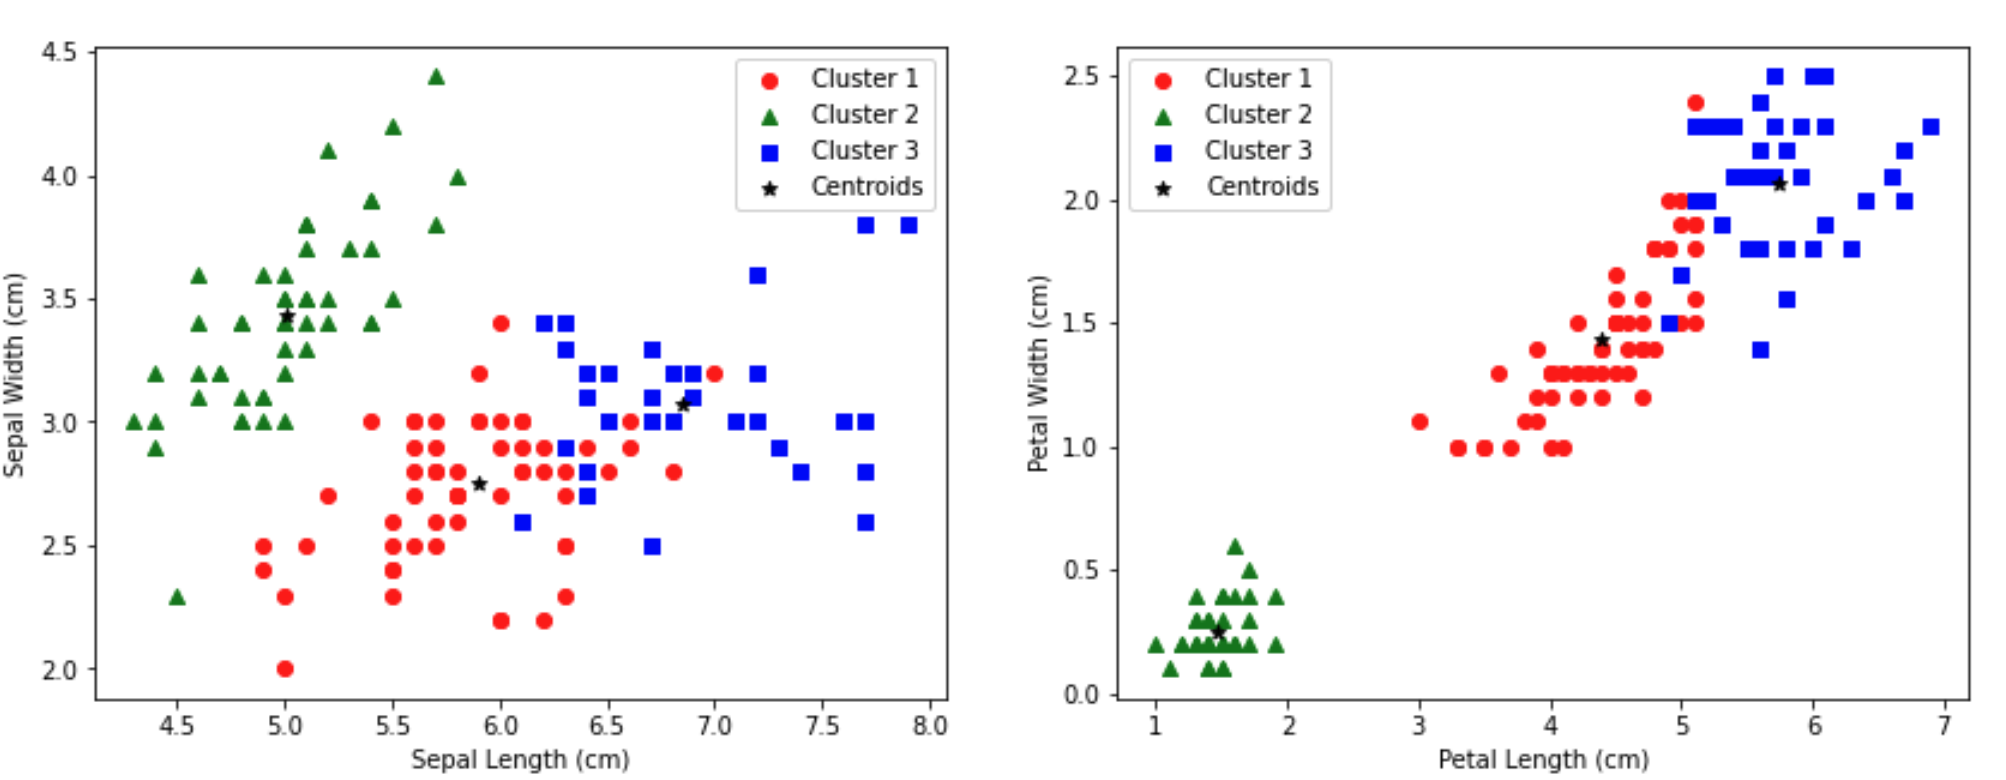

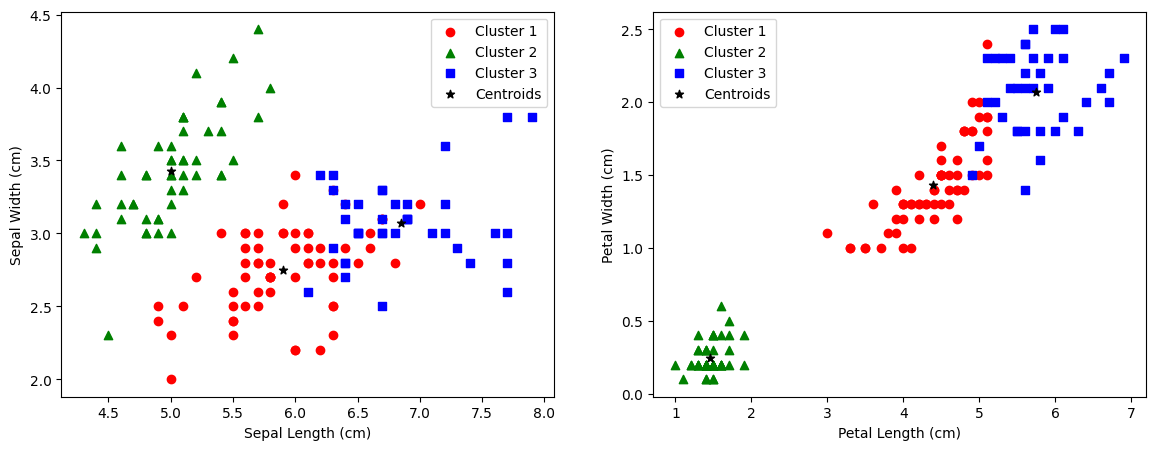

In [14]:
# plot the result
# show your result here
let_me_see(X, k, labels, centroids)

# Task 2 Evaluation
For Task 2, there are two sub-tasks need to be implemented:

### TODO 2.1
Calculate the **sum of squared error** (SSE). SSE is basically the sum of distance between each sample and its centroid.

SSE formula:
$$ SSE = \sum_{j}^{K}\sum_{i}^{N_j}(x_i - c_j)^2 $$

Here we use **Euclidian distances**, so this equation should hold:
    $$ (x_i - c_j)^2 = | x_i - c_j |^2 $$

Function name: calculate_sse

Input:
- "X": a 2D Numpy array with shape (N, d), which contains all the data samples.
- "label": a 1D Numpy array with shape (N, ), which is the cluster index for each sample.
- "centroids": a 2D Numpy array with shape (K, d), which contains the current centroids.

Output:
- "sse": a scalar with dtype=float, which is the SSE of all clusters.

**Grading**:
- Correctness: 0.5 if the function is implemented correctly.
- **Efficiency**: 0.5 if the function is implemented using numpy broadcasting, instead of for loop.

### TODO 2.2
Calculate the **Accuracy** (ACC). ACC is the percentage of samples that are correctly assigned to the same class as the ground truth.

ACC formula:
$$ ACC = \frac{1}{N} \sum_{i=1}^{N} \delta (y_i, \hat{y_i}) $$
where $\delta (y_i, \hat{y_i})$ is the indicator function, which is 1 if $y_i = \hat{y_i}$ and 0 otherwise.

Function name: calculate_acc

Input:
- "y": a 1D Numpy array with shape (N, ), which is the ground truth label.
- "y_pred": a 1D Numpy array with shape (N, ), which is the predicted label.

Output:
- "acc": a scalar with dtype=double, which is the ACC of all clusters.

### Code Cell of Task 2

In [17]:
############ Implement sse evalution function for clustering result ############
# sum of squared errors (SSE)
def sse(X, labels, centroids):
    # TODO 2.1
    # Hint: You may consider using
        # np.sum(...): https://numpy.org/doc/stable/reference/generated/numpy.sum.html
    square_d = (X - centroids[labels,:])**2
    sum_d = np.sum(square_d, axis=1)
    sse = np.sum(sum_d)
    return sse

############ Implement acc evalution function for classification result ############
# accuracy (ACC)
def accuracy(y, y_pred):
    # TODO 2.2
    # Hint: You may consider using
        # np.sum(...): https://numpy.org/doc/stable/reference/generated/numpy.sum.html
    num_correct = np.sum(y == y_pred)
    acc = num_correct / y.shape[0]
    return acc


### Expected SSE = 78.85

In [19]:
print(f'SSE: {sse(X, labels, centroids)}') # expected SSE should be around 78.85

SSE: 78.85144142614601



Kmean algorithm only give us the clustering result

We get cluster 1, cluster 2 ... cluster n

But it doesn't tell us which class certain cluster represents

So we need to align the cluster labels with the ground truth before caluculating the classification accuracy

### Expected ACC = 0.893

Accuracy: 0.8933333333333333


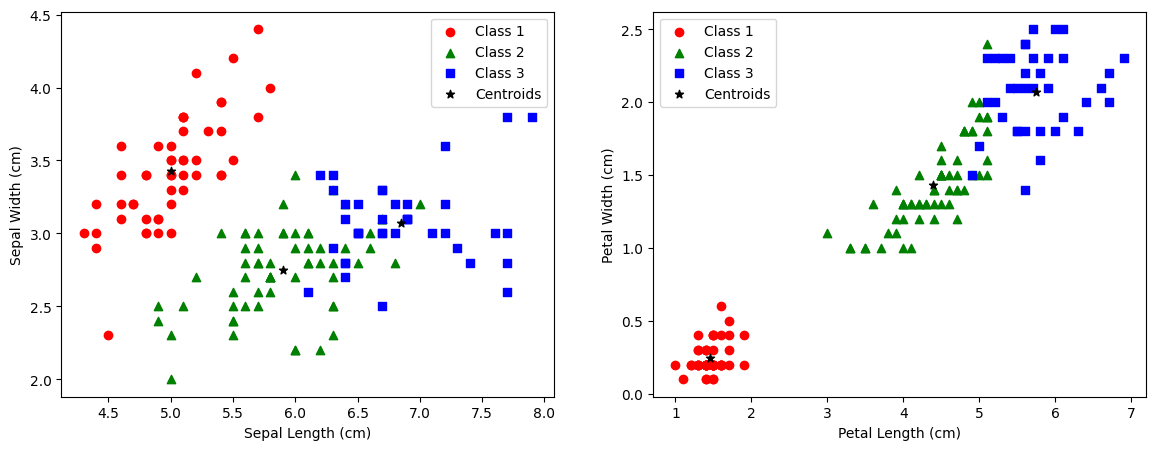

In [16]:
# align the labels with the ground truth
aligned_y_pred = align_labels(y, labels)

# calucate the accuracy
print(f'Accuracy: {accuracy(y, aligned_y_pred)}') # expected ACC should be around 0.8933

# plot the aligned labels
let_me_see(X, k, aligned_y_pred, centroids, True) # expected aligned label output should be the same as the task 1

# Try different "K"
Please try k = 1 ~ 6

for k > 6, the visualizer will fail, but the algorithm should still work.

In [20]:
############## set different k ################
k = 3  # possible k range from 1 to 6

distances[0:5]:
[[1.1045361  0.51961524 0.43588989]
 [1.62788206 0.50990195 0.70710678]
 [1.58745079 0.26457513 0.83066239]
 [1.71464282 0.33166248 0.87749644]
 [1.08627805 0.45825757 0.53851648]]
labels[0:5]:
[2 1 1 1 1]
centroids:
[[5.52       4.12       1.38       0.26      ]
 [4.74615385 3.20384615 1.41153846 0.21538462]
 [6.09663866 2.98067227 4.37058824 1.45378151]]
final centroids:
[[5.19375    3.63125    1.475      0.271875  ]
 [4.73181818 2.92727273 1.77272727 0.35      ]
 [6.31458333 2.89583333 4.97395833 1.703125  ]]
final labels:
[0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0
 0 1 0 0 1 1 0 0 1 0 1 0 0 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


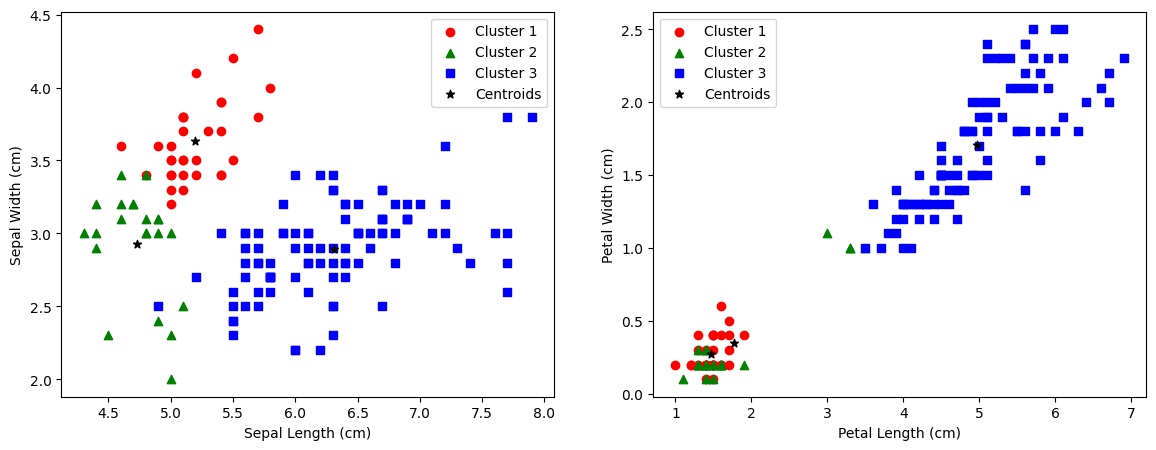

SSE: 142.7540625


In [21]:
# run k-means + plot + evalution
labels, centroids = KMeans(n_clusters=k).fit(X)

let_me_see(X, k, labels, centroids)

print(f'SSE: {sse(X, labels, centroids)}') # try to get least SSE as possible by adjusting k
# no evalution for classification result because the ground truth is 3 classes